In [13]:
import matplotlib.pyplot as plt
import json
import random
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np

In [2]:
person = '{"name": "Bob", "languages": ["English", "Fench"]}'
person_dict = json.loads(person)

# Output: {'name': 'Bob', 'languages': ['English', 'Fench']}
print( person_dict)

{'name': 'Bob', 'languages': ['English', 'Fench']}


121 datapoints
15.904756679999991


[array([12.65473637,  0.37343305]), array([46.30600708, 91.53426626])]

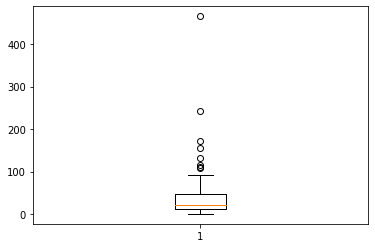

In [3]:
def makePairs(obj):
    return (obj["date"], obj["low"])
prices_low = []
with open("res.txt", "r") as fd:
    prices = json.loads(fd.read())
    print(str(len(prices)) + " datapoints")
    prices_low = list(map(makePairs, prices))

movements = []

for i in range(1, len(prices_low)):
    movements.append(abs(prices_low[i][1] - prices_low[i-1][1]))
print(movements[int(len(movements)/2)])

B = plt.boxplot(movements)
[item.get_ydata() for item in B['whiskers']]


95 104
8752.14215703
8656.90190286
8820.24891672486


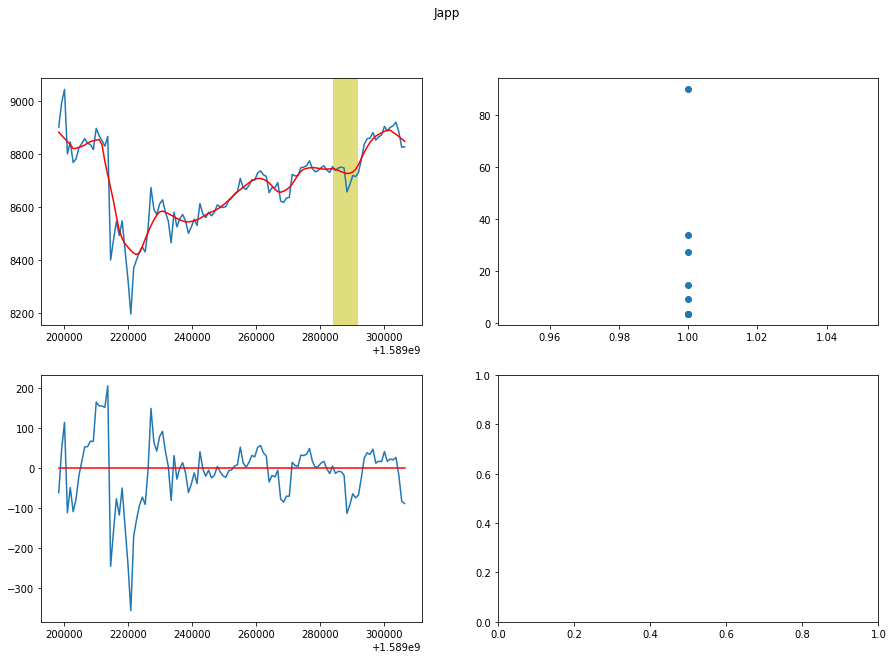

In [59]:
window_size = 10 # Datapoints

bottomIndex = random.randint(0, len(prices_low) - window_size)
topIndex = bottomIndex + 9 # random.randint(bottomIndex + window_size, len(prices_low))

print(bottomIndex, topIndex)
prices_low[bottomIndex: topIndex]

x_min = min(list(map(lambda x: x[1], prices_low[bottomIndex: topIndex])))
x_max = max(list(map(lambda x: x[1], prices_low[bottomIndex: topIndex])))


print(x_max)
print(x_min)

def scale(val):
    return (val-x_min)/(x_max-x_min)

window_y_values = list(map(lambda x: x[1], prices_low[bottomIndex: topIndex]))

# norm = list(map(scale, window_y_values))
#for i in range(0, len(norm)):
#    print(window_y_values[i], norm[i])

delta = []
for i in range(1, len(window_y_values)):
    delta.append(abs(window_y_values[i] - window_y_values[i-1]))

x_prices = list(map((lambda x: x[0]), prices_low))
#print(type(y_prices[0]))

y_prices = list(map((lambda x: x[1]), prices_low))
lo_1 = lowess(np.array(y_prices), np.array(range(0, len(x_prices))), is_sorted=True, it=3, frac=0.1)
lo_3 = lowess(np.array(y_prices), np.array(range(0, len(x_prices))), is_sorted=True, it=3, frac=0.3)
lo_6 = lowess(np.array(y_prices), np.array(range(0, len(x_prices))), is_sorted=True, it=3, frac=0.6)
lo_9 = lowess(np.array(y_prices), np.array(range(0, len(x_prices))), is_sorted=True, it=3, frac=0.9)

print(lo[5][1])
    
fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('Japp')

axs[0,0].axvspan(prices_low[bottomIndex][0], prices_low[topIndex][0], color='y', alpha=0.5, lw=0)
axs[0,0].plot(list(map((lambda x: x[0]), prices_low)), list(map((lambda x: x[1]), prices_low)))
axs[0,0].plot(list(map((lambda x: x[0]), prices_low)), list(map((lambda x: x[1]),lo_1)), color='r')



axs[0,1].scatter([1]*len(delta), delta)

noise = []
for i in range(len(y_prices)):
    trend = list(map((lambda x: x[1]), lo_3))[i]
    price = y_prices[i]
    noise.append(price-trend)

axs[1,0].plot(list(map((lambda x: x[0]), prices_low)), noise)
axs[1,0].plot(list(map((lambda x: x[0]), prices_low)), [0]*len(noise), color='r')

plt.show()